In [837]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [838]:
def read_ubyte_file(file_path):
    with open(file_path, 'rb') as f:
        # Read the magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        
        if magic_number == 2051:  # Magic number for images
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
            return images
        
        elif magic_number == 2049:  # Magic number for labels
            num_labels = int.from_bytes(f.read(4), 'big')
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels
        
        else:
            raise ValueError('Invalid magic number in file header')

train_images_path = './data/train-images-idx3-ubyte'
train_labels_path = './data/train-labels-idx1-ubyte'

train_images = read_ubyte_file(train_images_path)
train_labels = read_ubyte_file(train_labels_path)


In [839]:
print(train_labels.shape)
print(train_labels[0])

(60000,)
5


In [840]:
print(train_images.shape)
# go from (60000, 28, 28) to (60000, 784)
X = train_images.reshape(train_images.shape[0],train_images.shape[1]*train_images.shape[2])
# print(train_images[0])
X = X/255.0
# print(X[0])

(60000, 28, 28)


In [841]:
def init_params():
    # each pixel from image needs to point to 10 hidden neurons
    # initialized with normal distribution
    # W1 = np.random.randn(784, 10) * 0.01 
    # initialized with constant value
    W1 = np.full((784, 10), 0.0)   
    
    # weights = np.linspace(0, 0.5, num = 784*10)
    # np.random.shuffle(weights)
    # W1 = weights.reshape(784, 10)
    

    #1 bias for each of the 10 hidden neurons
    b1 = np.random.randn(1, 10) * 0.01   
    
    # each of the 10 hidden neurons needs to point to each of the 10 output neurons
    W2 = np.random.randn(10, 10) * 0.01  
    # 1 bias for each of the 10 output neurons
    b2 = np.random.randn(1, 10) * 0.01   
    
    return W1, b1, W2, b2

In [842]:
def ReLU(x):
    # normal ReLU
    # return np.maximum(0, x)
    
    # LEAKY RELU 
    return np.where(x > 0, x, 0.01 * x)

In [843]:
def soft_max(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

In [844]:
def one_hot_encode(labels, num_classes):
    # Initialize a matrix of zeros with shape (number of labels, number of classes)
    one_hot = np.zeros((labels.size, num_classes))
    
    # Set the corresponding index to 1 for each label
    one_hot[np.arange(labels.size), labels] = 1
    
    return one_hot

Y = one_hot_encode(train_labels, 10)

### Loss Function Explanation

We want to maximize the probability of choosing the correct category.

We can maximize the chances of having the correct probability by minimizing the negative log likelihood. We want to somehow maximize by minimizing.

#### Why use log?

Why we want to wrap everything with a logarithm? Computers are capable of almost anything, except exact numeric representation.

It can happen that after multiplying things together you will end up losing precision if the numbers are too high or too low. By using the log of a number like 1e-100, the log becomes something close to -230, much easier to be represented by a computer

### Why are we using a vector with the correct index noted?

imagine for some input we got the following probabilities: [0.1, 0.3, 0.5, 0.1], 4 possible classes. If the true answer would be the forth class, as a vector [0, 0, 0, 1], the likelihood of the current state of the model producing the input is:

0\*0.3 + 0\*0.1 + 0\*0.5 + 1\*0.1 = 0.1.

NLL: -ln(0.1) = 2.3

Instead, if the correct category would have been the third class [0, 0, 1, 0]:

0\*0.3 + 0\*0.1 + 1\*0.5 + 0\*0.1 = 0.5

NLL: -ln(0.5) = 0.69

<br>

*modified article from: https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6*

$$
\text{result} = \{ A2_{i, Y_{\text{int}, i}} \mid i \in \{0, 1, \ldots, m-1\} \}
\\
\\
result = A2[np.arange(m), Y_int] 
$$

In [845]:
def compute_loss(A2, Y):
    # m = number of examples
    m = Y.shape[0]
    
    # y_int is the index of the correct class in encoded vector
    Y_int = np.argmax(Y, axis=1)

    # Calculate the negative log likelihood
    # np.arrange(m) returns an array with values from 0 to m-1
    # 
    log_probs = -np.log(A2[np.arange(m), Y_int])
    
    # take the average loss
    loss = np.sum(log_probs) / m
    return loss

In [846]:
def forward(X, W1, b1, W2, b2, Y):
    Z1 = np.dot(X, W1) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = soft_max(Z2)
    return Z1, A1, Z2, A2

In [847]:
# all these derivatives are actually dL/d(whatever)
# we are finding out how each parameter affects the loss
def back_prop(X, Y, Z1, A1, Z2, A2, W1, W2, b1, b2, learning_rate):
    # used to find the normalized gradient
    # m = num of training examples in batch
    m = X.shape[0]
    
    # gradient of loss with respect to output
    dZ2 = A2 - Y
    
    # multiply the output of h1 by the change in the output
    dW2 = np.dot(A1.T, dZ2) / m
    
    # finds the average bias
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA = np.dot(dZ2, W2.T)
    
    # relu derivative
    dZ1 = dA * (Z1 > 0)
    
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

In [848]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [849]:
def step_decay(epoch, initial_lr=0.01, drop=0.5, epochs_drop=200):
    """
    Step decay schedule to decrease learning rate by a factor every few epochs.
    """
    return initial_lr * (drop ** (epoch // epochs_drop))

# Training

In [850]:
def train(X, Y, W1, b1, W2, b2, initial_lr, epochs):
    W1_list, b1_list, W2_list, b2_list = [], [], [], []
    for i in range(epochs):
        # learning_rate = step_decay(i, initial_lr)
        learning_rate = initial_lr
        
        # forward
        Z1, A1, Z2, A2 = forward(X, W1, b1, W2, b2, Y)
        loss = compute_loss(A2, Y)
        #backward
        dW1, db1, dW2, db2 = back_prop(X, Y, Z1, A1, Z2, A2, W1, W2, b1, b2, learning_rate)
        
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        if i % 50 == 0:
            print(f'Epoch {i}: loss = {loss}    lr = {learning_rate}')
            W1_list.append(np.round(W1, 3))
            b1_list.append(np.round(b1, 3))
            W2_list.append(np.round(W2, 3))
            b2_list.append(np.round(b2, 3))
    return W1, b1, W2, b2, W1_list, b1_list, W2_list, b2_list
        

In [851]:
W1, b1, W2, b2 = init_params()

In [852]:
num_epochs = 500
learning_rate = 0.1
W1, b1, W2, b2, W1_list, b1_list, W2_list, b2_list = train(X, Y, W1, b1, W2, b2, learning_rate, num_epochs)

Epoch 0: loss = 2.3026045953681264    lr = 0.1
Epoch 50: loss = 2.2818225575000675    lr = 0.1
Epoch 100: loss = 1.7647325773793439    lr = 0.1
Epoch 150: loss = 1.0020644599106279    lr = 0.1
Epoch 200: loss = 0.7114971487565517    lr = 0.1
Epoch 250: loss = 0.584455932176505    lr = 0.1
Epoch 300: loss = 0.5181529406597244    lr = 0.1
Epoch 350: loss = 0.47713010774719283    lr = 0.1
Epoch 400: loss = 0.44932841104942295    lr = 0.1
Epoch 450: loss = 0.42928924157290493    lr = 0.1


In [853]:
def get_predictions(A2):
    return np.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    # Convert one-hot encoded Y to integer labels
    Y_int = np.argmax(Y, axis=1)
    return np.sum(predictions == Y_int) / Y_int.size

#returns output
_, _, _, A2 = forward(X, W1, b1, W2, b2, Y)

# Get predictions from the output layer activations
predictions = get_predictions(A2)

# Calculate and print the accuracy
accuracy = get_accuracy(predictions, Y)
print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.88340


In [854]:
print(len(W1_list))

10


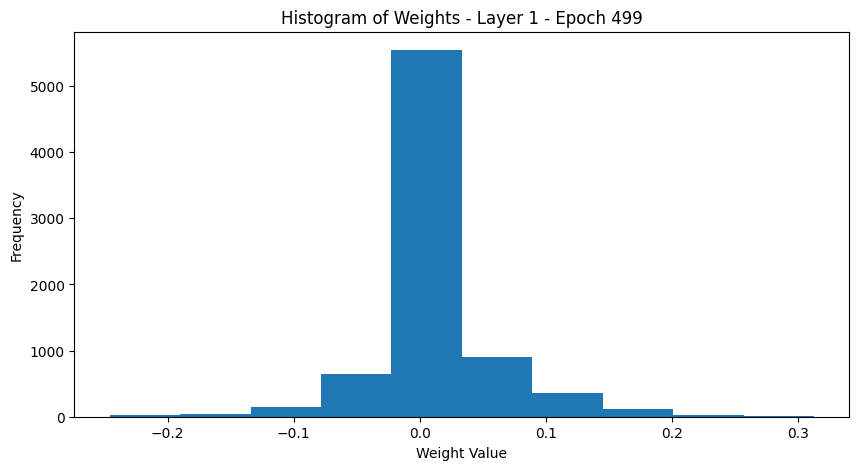

In [855]:
# def plot_heatmap(weights, epoch, layer):
#     plt.figure(figsize=(10, 5))
#     plt.imshow(weights, aspect='auto', cmap='viridis')
#     plt.colorbar()
#     plt.title(f'Heatmap of Weights - Layer {layer} - Epoch {epoch}')
#     plt.xlabel('Neurons')
#     plt.ylabel('Weights')
#     plt.show()

def plot_histogram(weights, epoch, layer):
    plt.figure(figsize=(10, 5))
    plt.hist(weights[epoch//50].flatten(), bins=10, alpha=1)
    plt.title(f'Histogram of Weights - Layer {layer} - Epoch {epoch}')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.show()
    
epochs = 499
# Visualize weights and biases
# plot_heatmap(W1, epoch*100, layer=1)
plot_histogram(W1_list, epochs, layer=1)
# plot_heatmap(W2, epoch*100, layer=2)
# plot_histogram(W2_list, epochs, layer=2)

In [856]:
# W1_rounded = np.round(W1_list, 2)
unique_values = np.unique(W1_list[0])
# print(len(W1_list))
print(W1_list[0])
print("Unique values in W1_list:", unique_values)
# print(len(unique_values))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Unique values in W1_list: [0.]


# Data Observations

Weights seem to follow some sort of predictable distribution while biases do not exhibit this behavior at all. 

Even when you initialize all the weights to be a constant value, they spread out to become more like a normal distribution after training.

One reason why this may be is because there are signigicantly more weights than biases. There are 784*10 weights for the first hidden layer while there are only 10 biases. Biases may follow some sort of predictable pattern, it is just difficult to see this with their lack of frequency. 


## Weight initializations

While creating this neural network, I experimented with different methods of initializing the weights. The standard method of using normal distribution to initialize weights of course works well. 

What was surprising to me was how resiliant yet simultaneously sensitive the network is to initializations. Even if you initialize all the weights to a constant value like 0, the model will still be able to learn quite effectively (accuracy of 0.82). However, if you keep pushing this value further and further from zero, it eventually just completely breaks and can't learn at all. 

Initilization results:
- Normal Distribution with 0.01 std deviation
    - 0.89
- -0.1
    - 0.11 accuracy
- -0.5
    - 0.11 accuracy
- -0.05
    - 0.11 accuracy
- -0.001
    - 0.11 accuracy
    - With Leaky ReLU
        - 0.89 (!!!)
- 0
    - 0.86 accuracy
    - With Leaky ReLU
        - 0.87
- 0.1
    - 0.89 accuracy (!!!)
- 0.125
    - 0.88 accuracy
- 0.175
    - 0.43 accuracy
- 0.2
    - 0.11 accuracy

One might predict that the model should be able to learn regardless of the initial weights, but this does not seem to be true at all. After about 1.5 initial weights, the model does HEAVILY struggles to learn. This is a very interesting result